# *RECONSTRUCTION SKILL EVALUATION*

The Analog Method (AM) is a statistical downscaling method very well suited for reconstruction of climatic time series. The reconstruction can reproduce the climatic characteristics of the local phenomena a certain region, based on the relationship between the large scale and the observed local weather patterns.

To validate the quality of the reconstructions is the important to look how the climatic characteristics are reproduced.

This notebook is an example of a fairly complete skill evaluation of the reconstructions and a comparision with the skill of the reanalysis. It contains the following elements:

- Time series skill (Bias, Heidke Skill Score, SSMSE and Taylor diagrams) for daily, monthly and yearly series
- Seasonality
- Equality of distributions
- Daily indices (Days above zero degree, days of precipitation above threshold)

In [1]:
import re
import os
import cfgrib
import datetime
import itertools
import rascal.utils
import rascal.analogs
import rascal.skill_evaluation

import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from scipy.stats import percentileofscore

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
initial_year = 1900
final_year = 2010

station_to_validate = "retiro"
variable_to_validate = "PCP"


In [3]:
# How to group the data when resampling the daily data to monthly or yearly
groupings = {
    "TMAX": "mean",
    "TMIN": "mean",
    "PCP": "sum"
}

reanalysis_variables = {
    "TMAX": ["SURF_167"],
    "TMIN": ["SURF_167"],
    "PCP": ["SURF_228"]
}

# How to group the data to daily resolution
reanalysis_grouping = {
    "TMAX": "1D_max",
    "TMIN": "1D_min",
    "PCP": "1D_sum"
}

units = {
    "TMAX": "[$^\circ$C]",
    "TMIN": "[$^\circ$C]",
    "PCP": "[mm]"
}

if variable_to_validate == "PCP":
    hydroyear=True
else: 
    hydroyear=False

### Paths

In [4]:
if variable_to_validate == "PCP":
    predictor = "SURF_71.162andSURF_72.162-SURF_71.162andSURF_72.162-1"
elif variable_to_validate in ["TMAX", "TMIN", "TMEAN"]:
    predictor = "925_129-SURF_167-1"
    
observations_directory = "./data/observations/"
reanalysis_directory = "/home/alvaro/data/NWP/era20c/"
#reconstructions_directory = "/".join([".", "output", variable_to_validate, predictor]) + "/"
reconstructions_directory = "/home/alvaro/Documents/Paper_05_RASCAL/output/"

# 0) LOAD DATA 

To evaluate the skill of the reconstructions the following data is needed:
- Observational data: To compare the reconstructions with the original data.
- Reconstructions: All the different reconstructions for the same variable in the same time, to compare how different methods perform in different tasks.
- Reanalysis data: To compare the added value of using RASCAL instead of using only the reanalysis.

## 0.1) STATION DATA

In [5]:
station = rascal.utils.Station(path= observations_directory + station_to_validate + '/')
station_daily = station.get_data(variable=variable_to_validate, skipna=False)
station_daily.index.name = "time"

## 0.2) REANALYSIS DATA

Load the reanalysis or reference model data. If the variable is part of an ensemble, all the members of the ensemble are loaded in a single dataframe as "'variable name'_'member number'". Once the data is extracted in the gridpoint of the station, a .csv file is saved, to save computation time in future runs.

In [6]:
reanalysis_data_name = "_".join([station.name, variable_to_validate, "ERA20C.csv"])

# Load the .csv file if it already exists
if os.path.exists(reanalysis_data_name):
    reanalysis_data = pd.read_csv(reanalysis_data_name, index_col=0)
    reanalysis_data.index = pd.to_datetime(reanalysis_data.index)
    reanalysis_data.index.name = "time"
    
# If it does not, extract the data in the gridpoint from the original files
else:
    
    if variable_to_validate in ensemble_variables:
        reanalysis_data = []
        for ensemble_member in range(reanalysis_ensemble_members):
            ensemble_member_data = rascal.skill_evaluation.get_reanalysis_in_gridpoint(
                reanalysis_directory,
                initial_year=initial_year,
                final_year=final_year,
                variable=reanalysis_variables[variable_to_validate],
                grid_point={"lat": station.latitude, "lon": station.longitude},
                file_format=".grib",
                grouping=reanalysis_grouping[variable_to_validate],
                ensemble_member=ensemble_member    
            )
            reanalysis_data.append(ensemble_member_data)
        reanalysis_data = pd.concat(reanalysis_data, axis=1)
        
    else:
        reanalysis_data = get_reanalysis_in_gridpoint(
            reanalysis_directory,
            initial_year=initial_year,
            final_year=final_year,
            variable=reanalysis_variables[variable_to_validate],
            grid_point={"lat": station.latitude, "lon": station.longitude},
            file_format=".grib",
            grouping=reanalysis_grouping[variable_to_validate],
            ensemble_member=None 
        )
        
    reanalysis_data.to_csv(reanalysis_data_name)


In [7]:
reanalysis_daily = rascal.skill_evaluation.get_reanalysis_ensemble(
    reanalysis_data, 
    variable_to_validate=variable_to_validate,
    freq="1D", 
    grouping=groupings[variable_to_validate]
)

## 0.3) RECONSTRUCTIONS DATA

In [8]:
reconstructions_daily = rascal.skill_evaluation.get_reconstruction_ensemble(
    filepath=reconstructions_directory,
    station_to_validate=station_to_validate, 
    variable_to_validate=variable_to_validate,
    freq='1D',
    grouping=groupings[variable_to_validate]
)

## 0.4) DAILY, MONTHLY AND YEARLY FREQUENCY

In [9]:
# Daily data 
rskill = rascal.skill_evaluation.RSkill(
    observations=station_daily,
    reconstructions=reconstructions_daily,
    reanalysis=reanalysis_daily
)

# Monthly data
rskill_1m = rskill.resample(freq="1m", grouping=groupings[variable_to_validate], hydroyear=hydroyear, skipna=False)

# Yearly data
rskill_1y = rskill.resample(freq="1Y", grouping=groupings[variable_to_validate], hydroyear=hydroyear, skipna=False)

# 1) TIME SERIES

## 1.1) Daily time series

In [10]:
initial_date = datetime.datetime(1900, 1, 1)
final_date = datetime.datetime(2010, 1, 1)

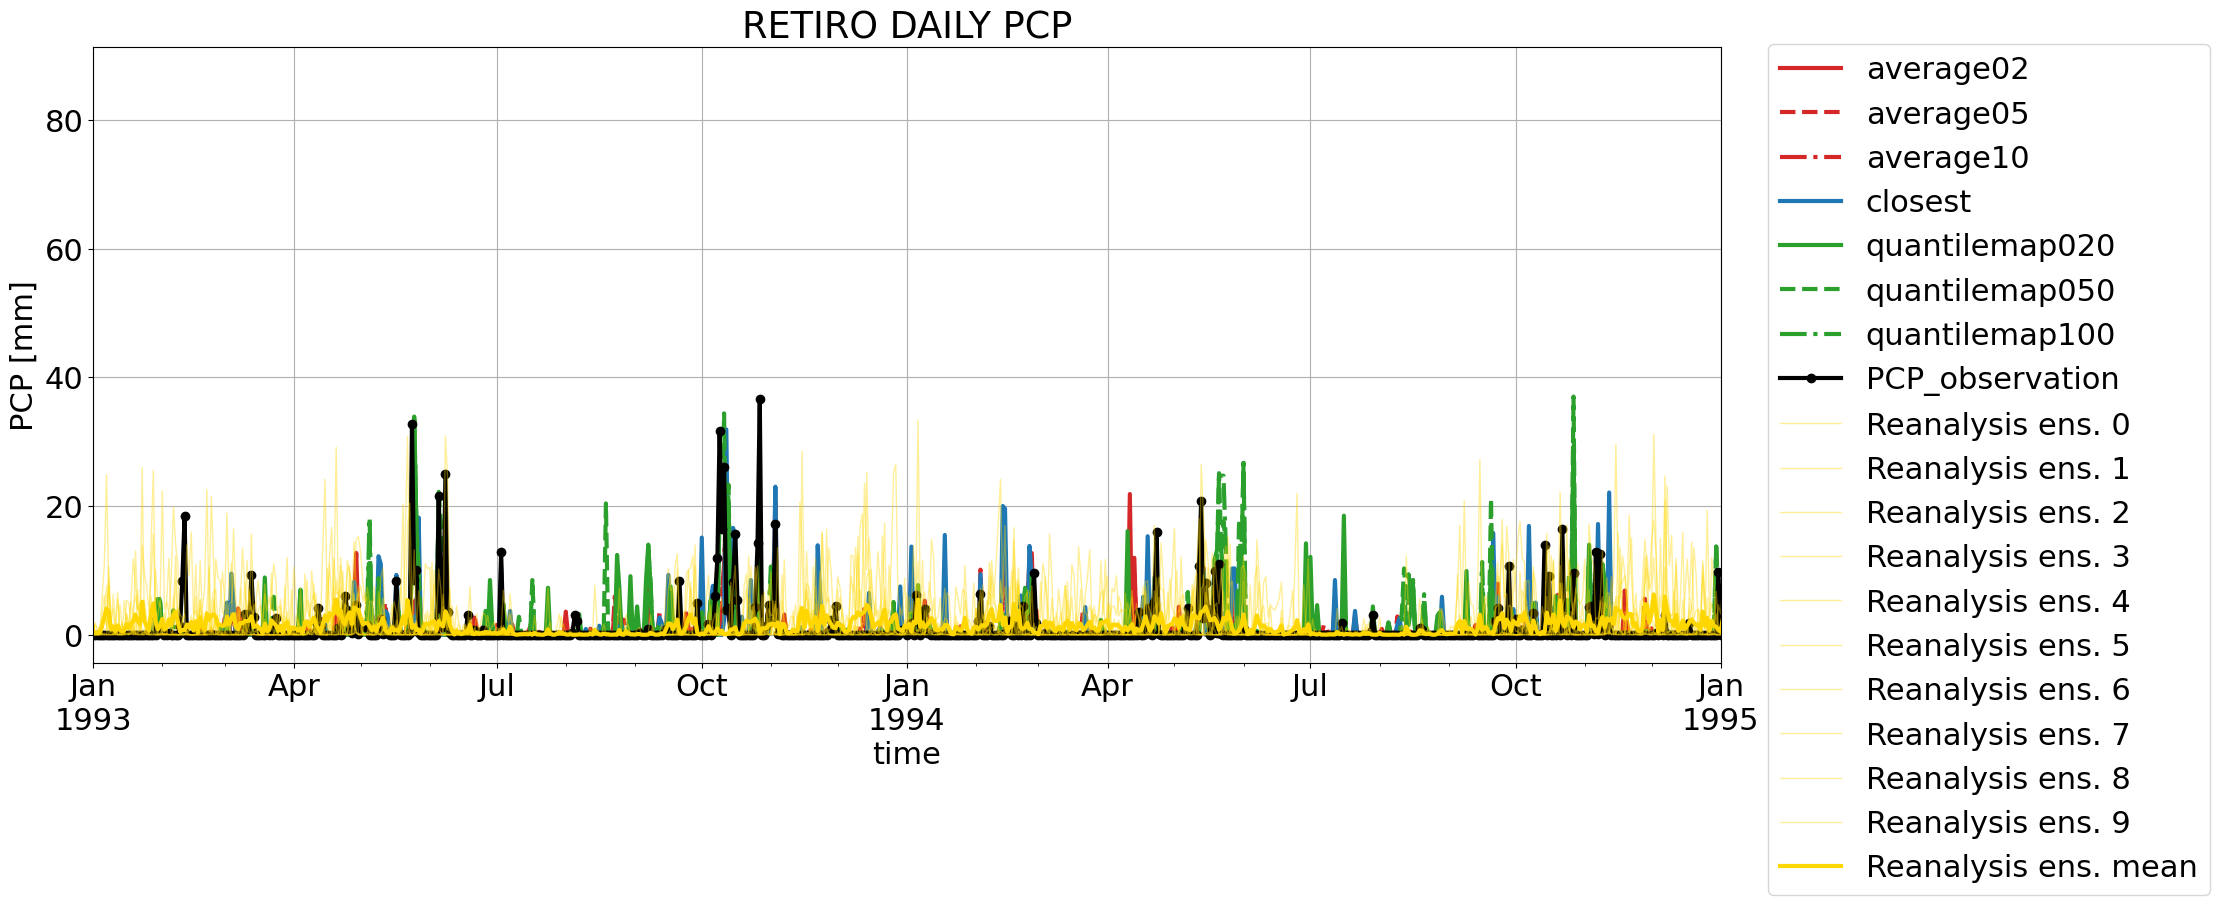

In [11]:
fig, ax = rskill.plotseries(start=datetime.datetime(1993, 1, 1), end=datetime.datetime(1995, 1, 1))
# fig, ax = rskill.plotseries(start=initial_date, end=final_date)
ax.set_title(station.name.upper() + " DAILY " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
plt.show()

## 1.2) Daily skill table

In [12]:
_, daily_skill = rskill.skill(threshold=1)

In [13]:
daily_skill

,bias,rmse,r2,std,bs
PCP_average02_reconstructions,0.001544,4.209366,0.284075,3.096474,0.212328
PCP_average05_reconstructions,0.023238,3.761125,0.352217,2.475153,0.233470
PCP_average10_reconstructions,0.033205,3.588179,0.391392,2.179563,0.241474
PCP_closest_reconstructions,-0.015691,4.881408,0.22066,3.866977,0.198538
PCP_quantilemap020_reconstructions,-0.100753,4.164961,0.393109,3.559143,0.191448
PCP_quantilemap050_reconstructions,-0.064138,4.0686,0.420625,3.576282,0.176701
PCP_quantilemap100_reconstructions,-0.04876,4.105613,0.423019,3.642729,0.174091
PCP_0_reanalysis,-0.087841,4.841376,0.015124,2.940682,0.316513
PCP_1_reanalysis,0.006455,4.726242,0.024365,2.803175,0.307813
PCP_2_reanalysis,0.055959,4.689693,0.020876,2.793195,0.306421


## 1.3) Daily Taylor diagram

(<Figure size 500x500 with 1 Axes>,
 <rascal.skill_evaluation.TaylorDiagram at 0x7f6fb50776a0>)

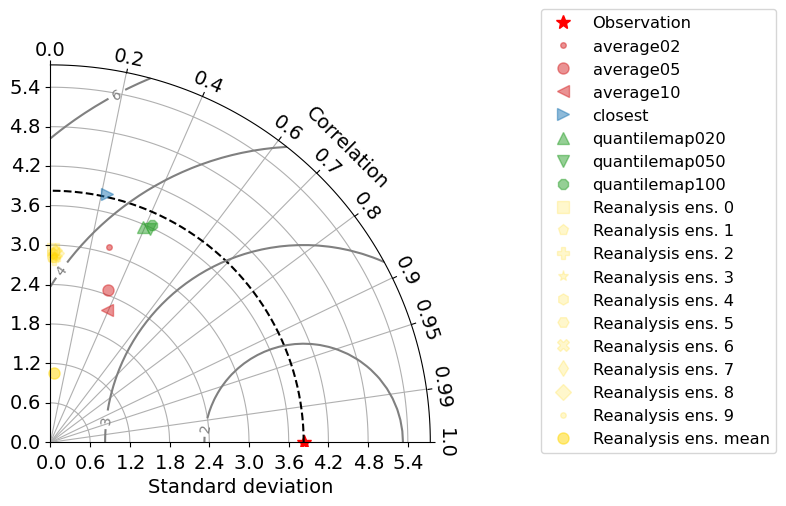

In [14]:
rskill.taylor()

## 1.4) Monthly time series

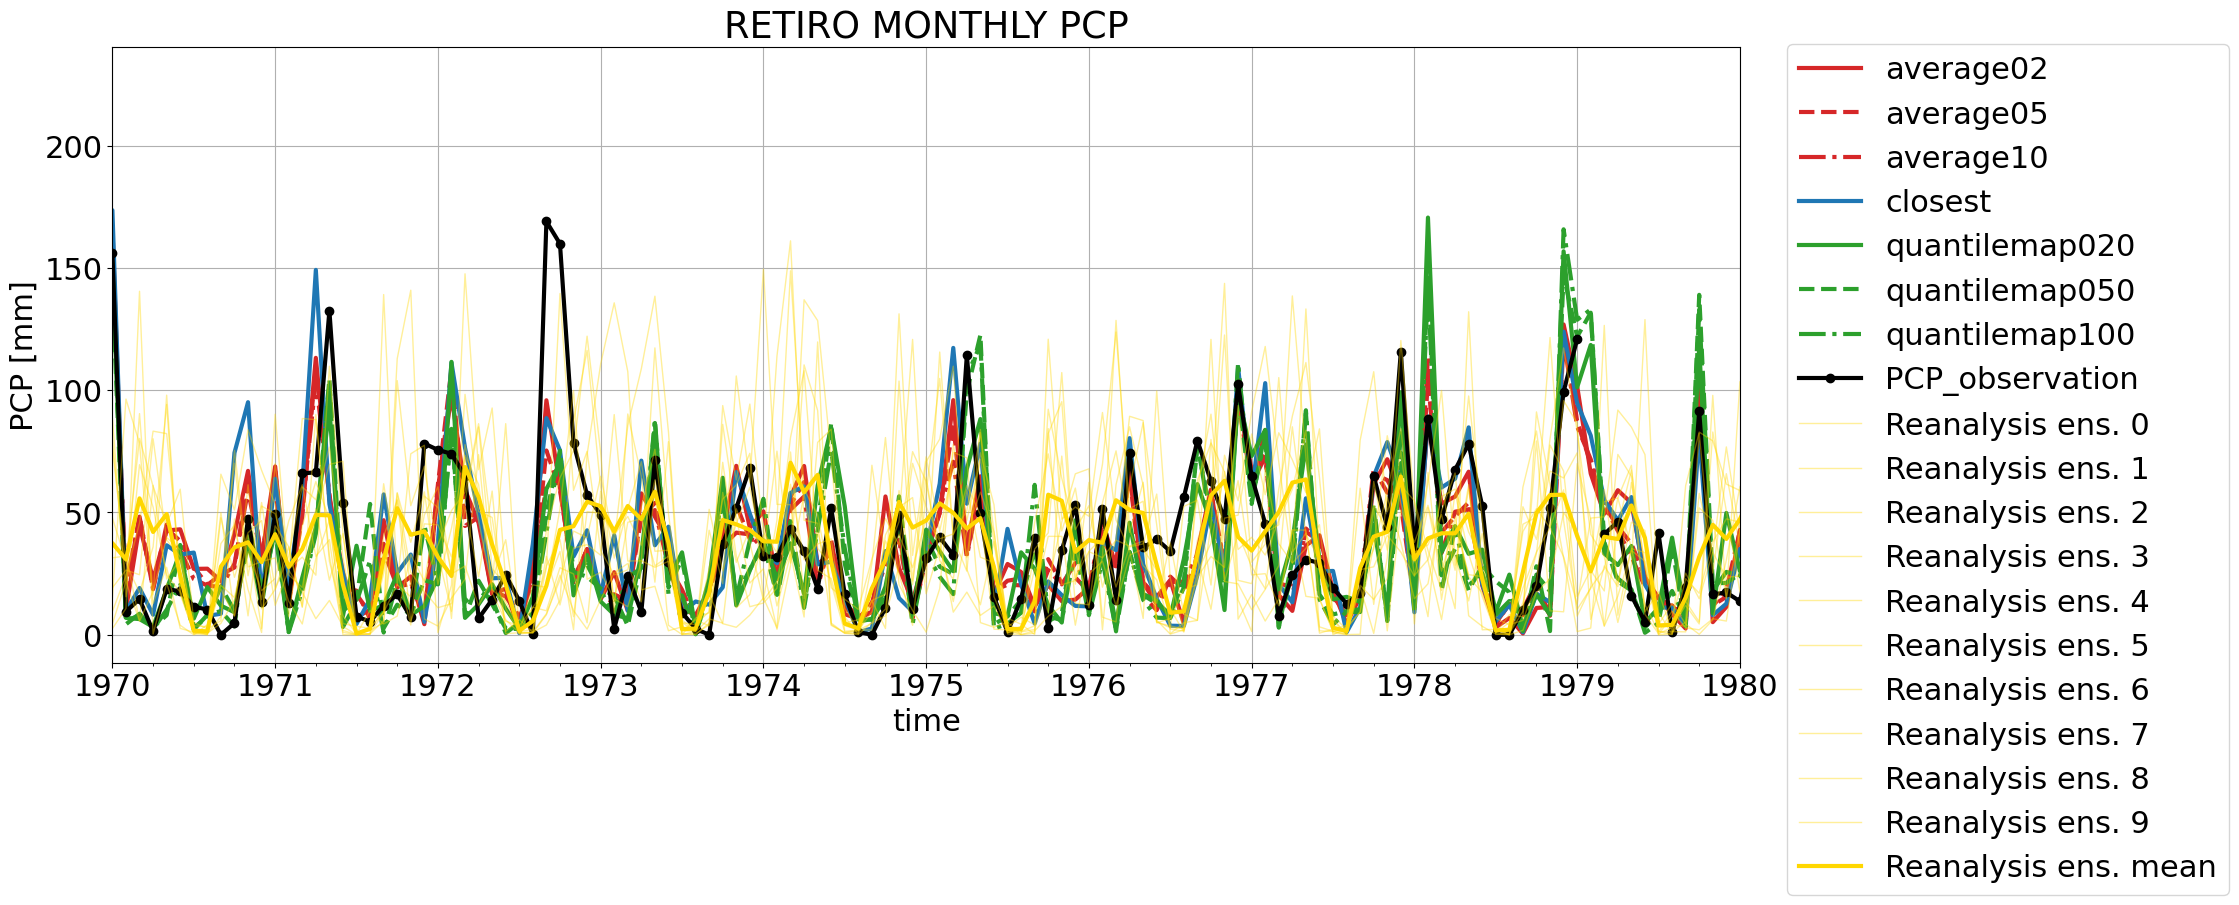

In [15]:
fig, ax = rskill_1m.plotseries(start=datetime.datetime(1970, 1, 1), end=datetime.datetime(1980, 1, 1))
# fig, ax = rskill_1m.plotseries(start=initial_date, end=final_date)
ax.set_title(station.name.upper() + " MONTHLY " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
plt.show()

## 1.5) Monthly skill table

In [16]:
_, monthly_skill = rskill_1m.skill()

In [17]:
monthly_skill

,bias,rmse,r2,std,bs
PCP_average02_reconstructions,-0.039841,26.625901,0.675825,30.629367,708.938616
PCP_average05_reconstructions,0.63088,24.55497,0.713589,28.766496,602.946536
PCP_average10_reconstructions,0.938457,23.585171,0.732806,27.628694,556.260301
PCP_closest_reconstructions,-0.548011,29.713409,0.629601,33.402123,882.886684
PCP_quantilemap020_reconstructions,-3.08939,28.138346,0.672585,33.495826,791.766499
PCP_quantilemap050_reconstructions,-1.954907,27.53437,0.696903,35.324774,758.141512
PCP_quantilemap100_reconstructions,-1.48183,28.721071,0.681913,36.148503,824.899934
PCP_0_reanalysis,-2.785985,42.956783,0.230146,33.041883,1845.285213
PCP_1_reanalysis,0.098552,41.409475,0.223562,31.18269,1714.744580
PCP_2_reanalysis,1.550664,41.131936,0.216945,31.318477,1691.836198


## 1.6) Monthly Taylor diagram

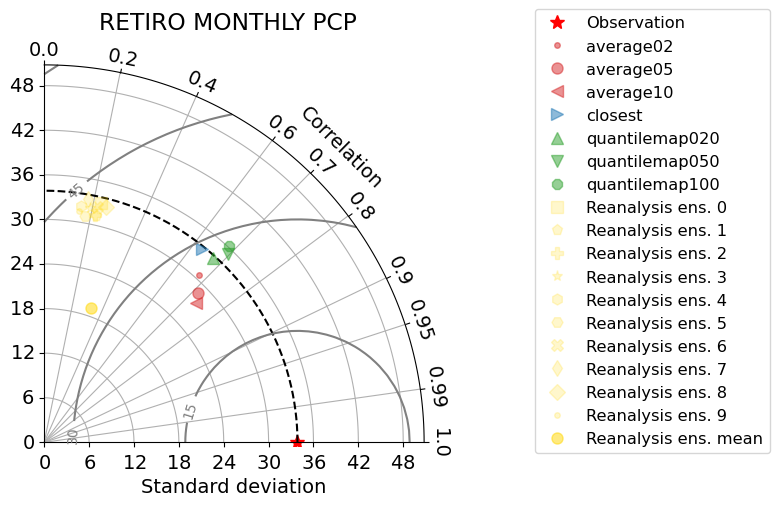

In [18]:
fig, ax = rskill_1m.taylor()
fig.suptitle(station_to_validate.upper() + " MONTHLY " + variable_to_validate)
plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/taylor_monthly_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png",
    bbox_inches = 'tight'
)

## 1.7) Yearly time series

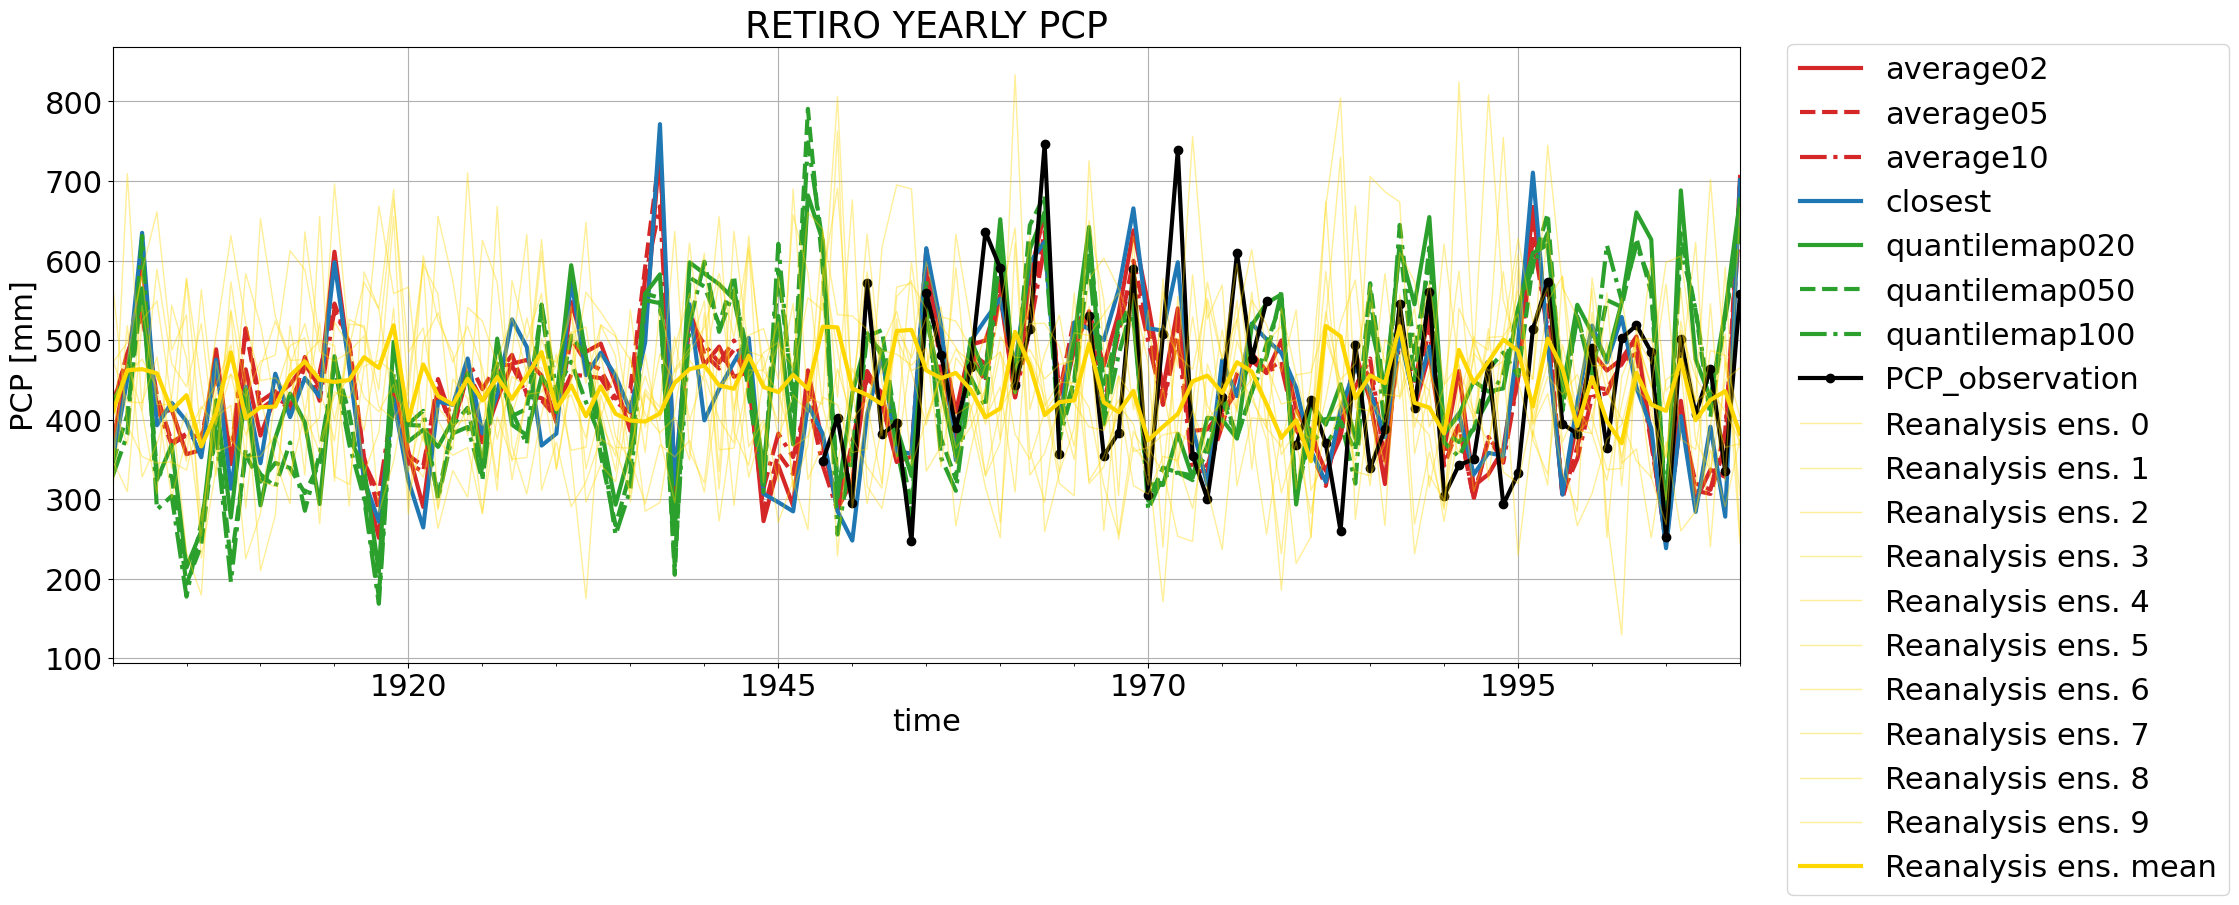

In [19]:
fig, ax = rskill_1y.plotseries(start=initial_date, end=final_date)
ax.set_title(station.name.upper() + " YEARLY " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/series_yearly_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)
plt.show()

## 1.8) Yearly skill table

In [20]:
_, yearly_skill = rskill_1y.skill()

In [21]:
yearly_skill

,bias,rmse,r2,std,bs
PCP_average02_reconstructions,0.218126,88.914955,0.650357,94.306567,7905.869214
PCP_average05_reconstructions,8.527583,86.478603,0.664142,87.279851,7478.548806
PCP_average10_reconstructions,11.74794,85.981383,0.663757,80.782813,7392.798304
PCP_closest_reconstructions,-5.931148,92.170025,0.646832,101.993454,8495.313443
PCP_quantilemap020_reconstructions,-37.431148,118.388832,0.484868,112.119989,14015.915574
PCP_quantilemap050_reconstructions,-24.577049,114.662207,0.490428,118.286744,13147.421639
PCP_quantilemap100_reconstructions,-18.647541,120.832472,0.434648,120.633129,14600.486393
PCP_0_reanalysis,-37.0095,163.62069,-0.105185,96.87035,26771.730323
PCP_1_reanalysis,1.066951,167.969439,-0.16062,99.115054,28213.732482
PCP_2_reanalysis,15.536242,169.505376,-0.256812,103.127934,28732.072563


## 1.9) Yearly Taylor diagram

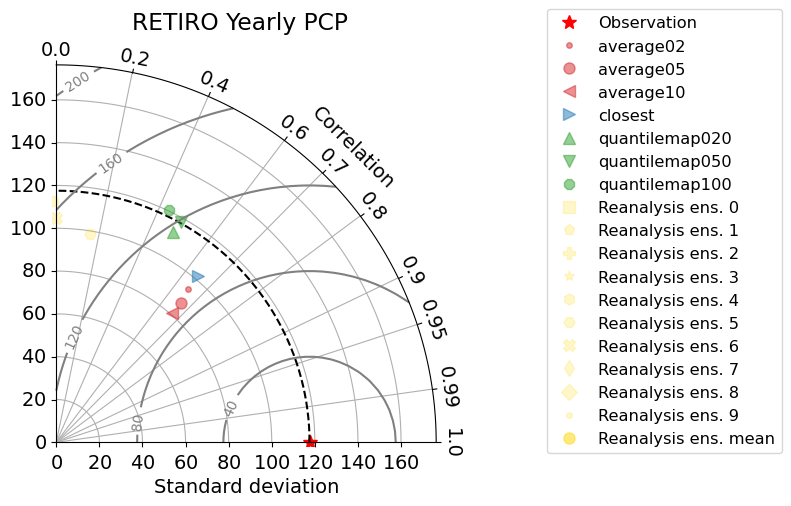

In [22]:
fig, ax = rskill_1y.taylor()
fig.suptitle(station_to_validate.upper() + " Yearly " + variable_to_validate)
plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/taylor_yearly_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)

# 2) SEASONALITY

## 2.1) Variable Annual Cycle

Text(0, 0.5, 'RETIRO MONTHLY PCP [mm]')

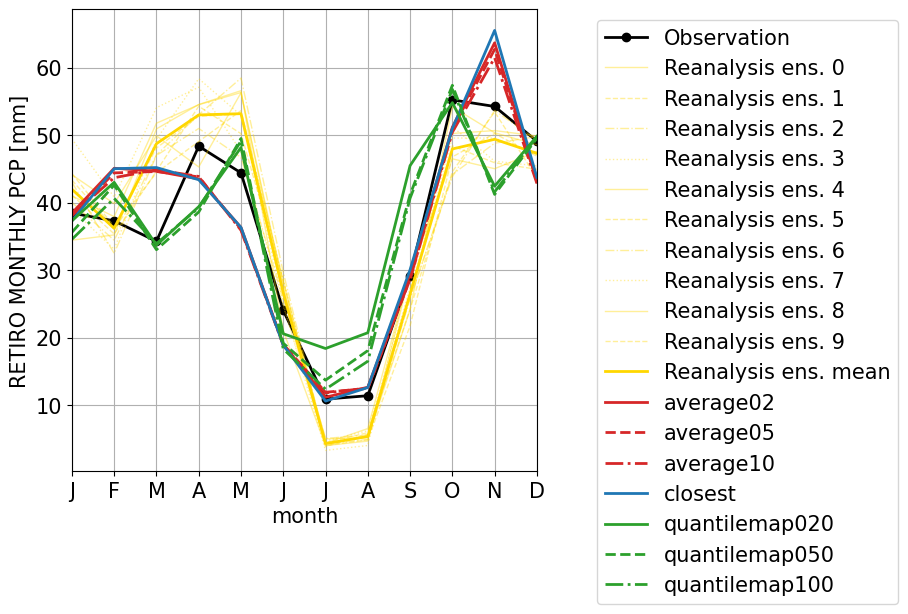

In [23]:
fig, ax = rskill_1m.annual_cycle(grouping="mean")
ax.set_xlabel("month")
ax.set_ylabel(station_to_validate.upper() + " MONTHLY " + variable_to_validate + " " + units[variable_to_validate])

## 2.2) Variable Standard Deviation Annual Cycle

Text(0, 0.5, 'RETIRO MONTHLY PCP std [mm]')

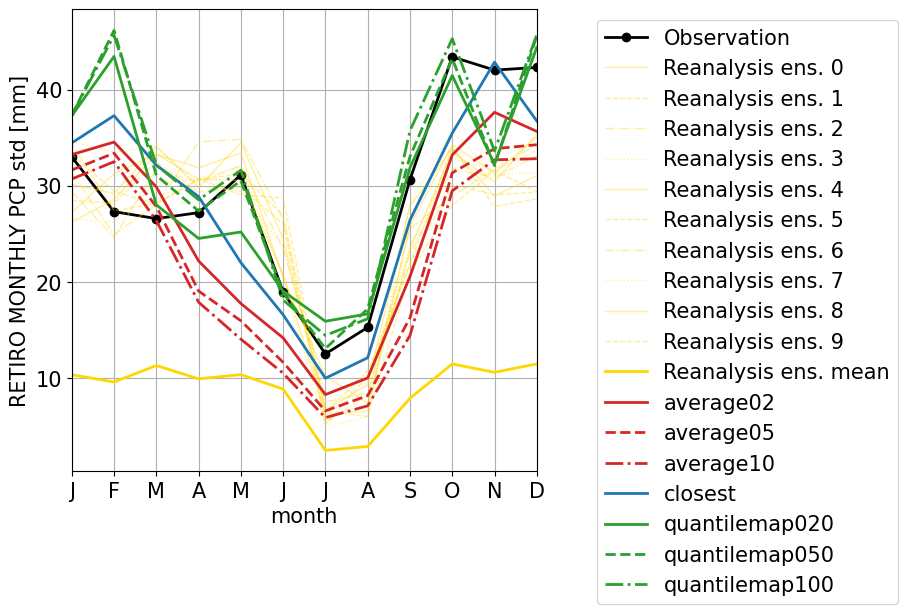

In [24]:
fig, ax = rskill_1m.annual_cycle(grouping="std")
ax.set_xlabel("month")
ax.set_ylabel(station_to_validate.upper() + " MONTHLY " + variable_to_validate + " std " + units[variable_to_validate])

# 5) DISTRIBUTIONS

### 5.1) Daily Quantile-Quantile Diagram

Text(0.5, 0, 'PCP daily reconstruction [mm]')

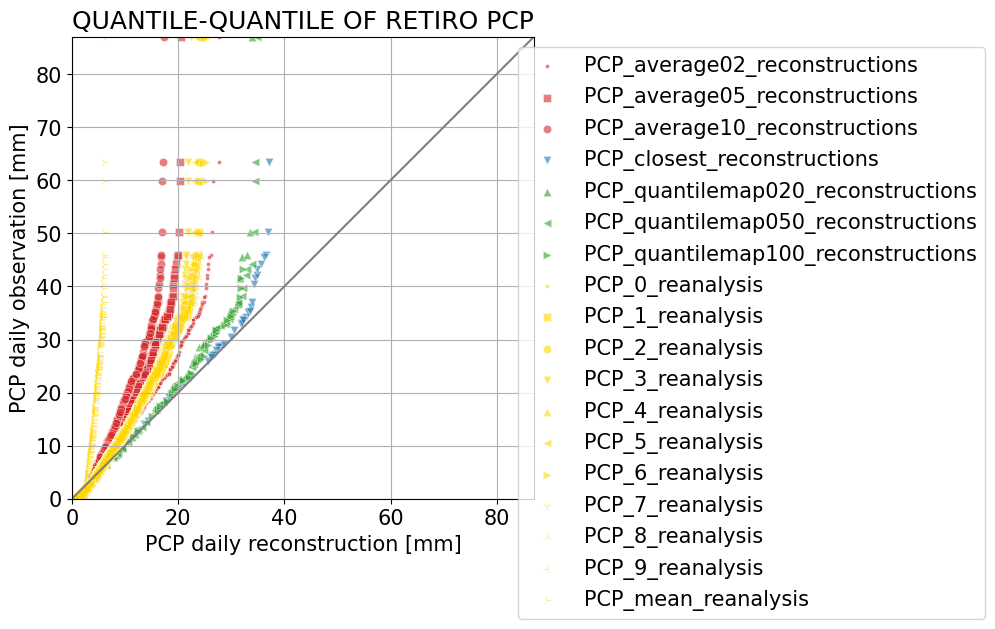

In [25]:
fig, ax = rskill.qqplot()
ax.set_title("QUANTILE-QUANTILE OF " + station_to_validate.upper() + " " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " daily observation " + units[variable_to_validate])
ax.set_xlabel(variable_to_validate + " daily reconstruction " + units[variable_to_validate])


NameError: name 'daily_ensemble' is not defined

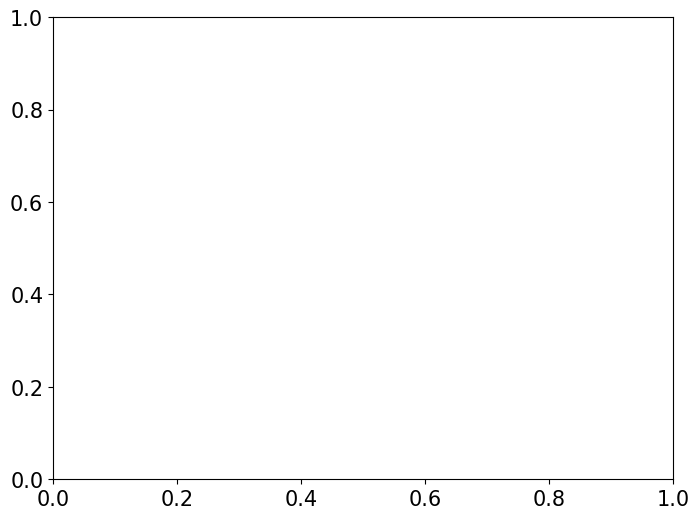

In [26]:
fig = plt.figure(figsize=(8, 6))
ax = fig.subplots()

for i, (model, reconstruction) in enumerate(daily_ensemble.items()):
    
    quantiles = rascal.skill_evaluation.quantile_plots(
        predicted=reconstruction, 
        observed=station_data_daily
    )

    if "closest" in model:
        color = "tab:blue"
    elif "average" in model:
        color = "tab:red"
    elif "quantilemap" in model:
        color = "tab:green"
    else:
        color = "grey"
        
    sns.scatterplot(
        data=quantiles, 
        x='Predicted', 
        y='Observed', 
        ax=ax, 
        alpha=0.6,
        color=color,
        label=model,
        marker=list(Line2D.markers.keys())[i]
    )
        
reanalysis_quantiles = rascal.skill_evaluation.quantile_plots(
        predicted=reanalysis_data_daily, 
        observed=station_data_daily
    )

sns.scatterplot(
        data=reanalysis_quantiles, 
        x='Predicted', 
        y='Observed', 
        ax=ax, 
        alpha=0.6,
        color="grey",
        label="reanalysis"
)
ax.axline([0, 0], [1, 1], color='grey')
ax.set_aspect('equal')
ax.grid()
ax.set_title("QUANTILE-QUANTILE OF " + station.name.upper() + " " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " daily observation " + units[variable_to_validate])
ax.set_xlabel(variable_to_validate + " daily reconstruction " + units[variable_to_validate])
ax.legend(loc="upper right", bbox_to_anchor=[1.6, 1.01], ncol=int(np.ceil(len(daily_ensemble)/20)))

if variable_to_validate == "PCNR":
    ax.set_ylim(0, 150)
    ax.set_xlim(0, 150)

# 6) INDICES

In [ ]:
def get_days_above_threshold(ensemble, variable, threshold, freq, inverse=False):

    ensemble_days_above_threshold = pd.DataFrame()

    for model, data in ensemble.items():
     
        days_above_threshold = data.copy()
        
        if inverse: 
            days_above_threshold[variable][data[variable] > threshold] = 0
            days_above_threshold[variable][data[variable] <= threshold] = 1
        else:
            days_above_threshold[variable][data[variable] > threshold] = 1
            days_above_threshold[variable][data[variable] <= threshold] = 0
    
        monthly_days_above_threshold = days_above_threshold[variable].resample(freq).sum().to_frame()
        monthly_days_above_threshold["model"] = model
    
        ensemble_days_above_threshold = pd.concat([ensemble_days_above_threshold, monthly_days_above_threshold], axis=0)

    ensemble_days_above_threshold = ensemble_days_above_threshold.reset_index()
    
    return ensemble_days_above_threshold


### 6.1) Monthly days above certain threshold 

In [ ]:
if variable_to_validate == "PCNR":
    threshold = 1
    inverse = False
elif variable_to_validate in ["TMAX", "TMIN", "TMEAN"]:
    threshold = 0
    inverse = True

extended_daily_ensemble = daily_ensemble.copy()     
extended_daily_ensemble["observations"] = station_data_daily
extended_daily_ensemble["reanalysis"] = reanalysis_data_daily


days_above_threshold = get_days_above_threshold(
    ensemble=extended_daily_ensemble, 
    variable=variable_to_validate,
    threshold=threshold, 
    freq="m",
    inverse=inverse
)


In [ ]:
days_above_threshold

In [ ]:
if inverse:
   threshold_label = "BELOW " + str(threshold) + units[variable_to_validate].replace("[", "").replace("]", "") 
else:
   threshold_label = "ABOVE " + str(threshold) + units[variable_to_validate].replace("[", "").replace("]", "")  

plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=days_above_threshold, 
    x="time", 
    y=variable_to_validate, 
    hue="model", 
    palette="Spectral"
)
days_above_threshold.loc[days_above_threshold["model"] == "observations"].set_index("time")[variable_to_validate].plot(ax=ax, color="black", label="Observations", marker="o")
days_above_threshold.loc[days_above_threshold["model"] == "reanalysis"].set_index("time")[variable_to_validate].plot(ax=ax, color="grey", label="Reanalysis", marker="o")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.2, 1], fontsize=16)

ax.set_ylabel("NUMBER OF DAYS", fontsize=24)
ax.set_title(station.name.upper() + " NUMBER OF DAYS OF " + variable_to_validate + " " + threshold_label)
ax.grid()


plt.show()

In [ ]:
days_above_threshold = days_above_threshold.rename(columns={"model": "similarity_method"})
threshold_series = rascal.skill_evaluation.ensemble_to_dict(days_above_threshold.loc[days_above_threshold["similarity_method"] != "observations"])

threshold_monthly_std, threshold_monthly_skill = rascal.skill_evaluation.get_skill(
    observation=days_above_threshold.loc[days_above_threshold["similarity_method"] == "observations"].set_index("time")[variable_to_validate].to_frame(), 
    simulations=threshold_series,
    variable=variable_to_validate
)

In [ ]:
threshold_monthly_skill

In [ ]:
rascal.skill_evaluation.taylor_test(threshold_monthly_std, threshold_monthly_skill)

### 6.2) Yearly days above certain threshold 

In [ ]:
days_above_threshold = get_days_above_threshold(
    ensemble=extended_daily_ensemble, 
    variable=variable_to_validate,
    threshold=threshold, 
    freq="Y",
    inverse=inverse
)


In [ ]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=days_above_threshold, 
    x="time", 
    y=variable_to_validate, 
    hue="model", 
    palette="Spectral"
)
days_above_threshold.loc[days_above_threshold["model"] == "observations"].set_index("time")[variable_to_validate].plot(ax=ax, color="black", label="Observations", marker="o")
days_above_threshold.loc[days_above_threshold["model"] == "reanalysis"].set_index("time")[variable_to_validate].plot(ax=ax, color="grey", label="Reanalysis", marker="o")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.2, 1], fontsize=16)

ax.set_ylabel("NUMBER OF DAYS", fontsize=24)
ax.set_title(station.name.upper() + " NUMBER OF DAYS OF " + variable_to_validate + " " + threshold_label)
ax.grid()


plt.show()

In [ ]:
days_above_threshold = days_above_threshold.rename(columns={"model": "similarity_method"})
threshold_series = rascal.skill_evaluation.ensemble_to_dict(days_above_threshold.loc[days_above_threshold["similarity_method"] != "observations"])

threshold_yearly_std, threshold_yearly_skill = rascal.skill_evaluation.get_skill(
    observation=days_above_threshold.loc[days_above_threshold["similarity_method"] == "observations"].set_index("time")[variable_to_validate].to_frame(), 
    simulations=threshold_series,
    variable=variable_to_validate
)

In [ ]:
threshold_yearly_skill

In [ ]:
rascal.skill_evaluation.taylor_test(threshold_yearly_std, threshold_yearly_skill)

### 6.3) Seasonal Skill Table

In [ ]:
seasons = [
    [12, 1, 2],
    [3, 4, 5],
    [6, 7, 8],
    [9, 10, 11]
]
seasons_name = [
    "DJF",
    "MAM",
    "JJA",
    "SON"
]


fig1 = plt.figure(figsize=(20, 4))
ax1 = fig1.subplots(1, 4)

fig2 = plt.figure(figsize=(20, 4))
ax2 = fig2.subplots(1, 4)

fig3 = plt.figure(figsize=(20, 4))
ax3 = fig3.subplots(1, 4)

for i, season in enumerate(seasons):
    seasonal_observation = station_data_daily.loc[station_data_daily.index.month.isin(season)]
    seasonal_reanalysis = reanalysis_data_daily.loc[reanalysis_data_daily.index.month.isin(season)]
    seasonal_ensemble = {}
    for k, v in daily_ensemble.items():
        seasonal_ensemble[k] = v.loc[v.index.month.isin(season)]

    _, seasonal_skill = rascal.skill_evaluation.get_skill(
        observation=seasonal_observation, 
        simulations=seasonal_ensemble,
        variable=variable_to_validate,
        reference_model=seasonal_reanalysis,
        threshold=threshold
    )"lightgrey""lightgrey"
    
    seasonal_skill.index.name = "model"
    seasonal_skill = seasonal_skill.reset_index()
    seasonal_skill["method"] = seasonal_skill["model"].apply(lambda x: re.sub(r'[0-9]', '', x))

    
    p1 = sns.barplot(data=seasonal_skill, x="model", y="hss", ax=ax1[i], hue="method")
    p1.set_xticklabels(labels=seasonal_skill["model"], rotation=90)
    p1.set_ylim(-1, 1)
    ax1[i].set_title(seasons_name[i])
    ax1[i].get_legend().remove()
    
    p2 = sns.barplot(data=seasonal_skill, x="model", y="bs", ax=ax2[i], hue="method")
    p2.set_xticklabels(labels=seasonal_skill["model"], rotation=90)
    ax2[i].set_title(seasons_name[i])
    ax2[i].get_legend().remove()
        
    p3 = sns.barplot(data=seasonal_skill, x="model", y="ssmse", ax=ax3[i], hue="method")
    p3.set_xticklabels(labels=seasonal_skill["model"], rotation=90)
    ax3[i].set_title(seasons_name[i])
    ax3[i].get_legend().remove()
        
plt.show()
